In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import seaborn as sns

In [2]:
df = pd.read_csv('/Users/estyle-150/github/my_signage/data/processed/processed20240826.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# 訓練データをとる
train_data = df[df['is_train'] == 1].copy()

# テストデータをとる
test_data = df[df['is_train'] == 0].copy()

# 訓練データから不要な列（'is_train'）を削除
train_data.drop(['is_train'], axis=1, inplace=True)

# テストデータから不要な列を削除
test_data.drop(['y','is_train'], axis=1, inplace=True)

display(train_data.head(), test_data.head())


,y,client,close,price_am,price_pm,price,year,month,weekday,y_lag_365,...,price_am_lag_7,price_am_lag_365,price_pm_lag_1,price_pm_lag_7,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_pm_moving_avg_7,price_pm_moving_avg_30,day
datetime,,,,,,,,,,,,,,,,,,,,,
2010-07-01,17,0,0,0.192308,0.076923,0.134615,2010,7,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2010-07-02,18,0,0,0.692308,0.423077,0.557692,2010,7,4,NaN,...,NaN,NaN,0.076923,NaN,NaN,NaN,NaN,NaN,NaN,2
2010-07-03,20,0,0,1.807692,1.192308,1.500000,2010,7,5,NaN,...,NaN,NaN,0.423077,NaN,NaN,NaN,NaN,NaN,NaN,3
2010-07-04,20,0,0,1.407407,0.925926,1.166667,2010,7,6,NaN,...,NaN,NaN,1.192308,NaN,NaN,NaN,NaN,NaN,NaN,4
2010-07-05,14,0,0,0.346154,0.192308,0.269231,2010,7,0,NaN,...,NaN,NaN,0.925926,NaN,NaN,NaN,NaN,NaN,NaN,5


,client,close,price_am,price_pm,price,year,month,weekday,y_lag_365,price_am_lag_1,price_am_lag_7,price_am_lag_365,price_pm_lag_1,price_pm_lag_7,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_pm_moving_avg_7,price_pm_moving_avg_30,day
datetime,,,,,,,,,,,,,,,,,,,,
2016-04-01,1,0,3.0,2.0,2.5,2016,4,4,60.0,5.0,4.0,2.0,4.0,5.0,2.0,4.428571,2.400000,3.857143,2.266667,1
2016-04-02,0,0,5.0,5.0,5.0,2016,4,5,75.0,3.0,5.0,2.0,2.0,5.0,1.0,4.428571,2.566667,3.857143,2.433333,2
2016-04-03,1,0,2.0,2.0,2.0,2016,4,6,86.0,5.0,5.0,4.0,5.0,4.0,3.0,4.000000,2.600000,3.571429,2.500000,3
2016-04-04,1,0,1.0,1.0,1.0,2016,4,0,69.0,2.0,4.0,2.0,2.0,4.0,2.0,3.571429,2.566667,3.142857,2.500000,4
2016-04-05,0,0,1.0,1.0,1.0,2016,4,1,61.0,1.0,4.0,1.0,1.0,4.0,1.0,3.142857,2.566667,2.714286,2.500000,5


In [3]:
from sklearn.model_selection import KFold
import optuna.integration.lightgbm as lgb_op
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error

N = 365
X_train = train_data.drop(['y'], axis=1)[:-N]
y_train = train_data['y'][:-N]

X_test = train_data.drop(['y'], axis=1)[-N:]
y_test = train_data['y'][-N:]

# LightGBM用のデータセット
lgb_train = lgb.Dataset(X_train, y_train)
lgb.test = lgb.Dataset(X_test, y_test)

# 評価基準 
params = {"objective" : "mse", 
              "metric" : "mse", 
              "num_leaves" : 25,
              "early_stopping_rounds" : 10,
              "verbosity": -1}

# 回帰モデル作成
model = lgb.train(params, lgb_train, valid_sets=lgb.test)

# 予測
test_pred = model.predict(X_test)
pred_df = pd.concat([y_test.reset_index(drop=True), pd.Series(test_pred)], axis = 1)
pred_df.columns = ['true', 'pred']
pred_df

rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print('RMSE:',round(rmse,3))

RMSE: 9.8


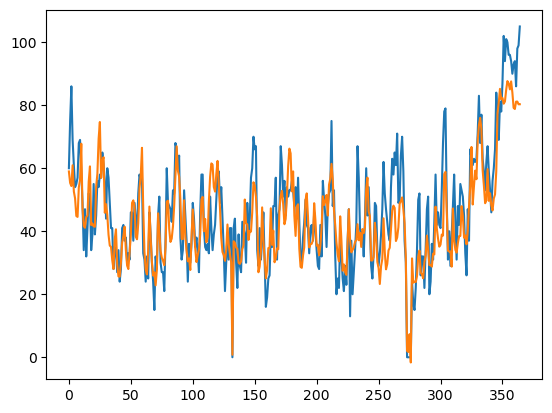

In [4]:
# 可視化
plt.plot(pred_df)

In [5]:
pred_submit = model.predict(test_data)
submit = pd.DataFrame({'date' : test_data.index, 'pred' : pred_submit})
submit.reset_index(drop=True)
submit.columns = submit.iloc[0]
#submit.to_csv('signate_ligthGBM_4.csv', index=False)

In [6]:
submit

,2016-04-01 00:00:00,66.526128
0,2016-04-01,66.526128
1,2016-04-02,59.444296
2,2016-04-03,65.107397
3,2016-04-04,66.929182
4,2016-04-05,60.985327
...,...,...
360,2017-03-27,79.490999
361,2017-03-28,79.490999
362,2017-03-29,80.019946
363,2017-03-30,79.155129


In [8]:
# oputunaによるハイパーパラメータのチューニング
import optuna

In [9]:
# 固定値のハイパーパラメータ
params_base = {
    'objective' : 'mae',    # 損失関数
    'random_seed' : 123,    
    'learnig_rate' : 0.02,  # １回のブースティングで加算する重みの比率
    'min_data_in_bin' : 3,  # ヒストグラムの１つのbinに含まれる最小のレコード数
    'bagging_freq' : 0,
    'verbose' : -1,
}

# ハイパーパラメータの探索範囲
def objective(trial):
    params_turning = {
        'num_leaves' : trial.suggest_int('num_leaves', 50, 200),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 2, 30),
        'max_bins' : trial.suggest_int('max_bin', 200, 400),
        'bagging_fraction' : trial.suggest_float('bagging_fraction', 0.8, 0.95),
        'feature_fraction' : trial.suggest_float('eature_fraction', 0.35, 0.65),
        'min_gain_to_split' : trial.suggest_float('min_gain_to_split', 0.01, 1, log=True),
        'lambda_11' : trial.suggest_float('lambda_11', 0.01, 1, log=True),
        'lambda_12' : trial.suggest_float('lambda_12', 0.01, 1, log=True),
    }
    
    # 探索用ハイパーパラメータの設定
    params_turning.update(params_base)
    lgb_train = lgb.Dataset(x_tr, y_tr)
    lgb_eval = lgb.Dataset(x_va, y_va)

    #探索用ハイパーパラメータで学習
    model = lgb.train(params_turning,
                      lgb_train,
                      num_boost_round=3000,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(100),
                                 lgb.log_evaluation(500)])
    y_va_pred = model.predict(x_va,
                              num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print('')
    return score

In [10]:
x_tr = X_train
x_va = X_test
y_tr = y_train
y_va = y_test

In [11]:
# ハイパーパラメータの最適化の実行
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=0), direction='minimize')
study.optimize(objective, n_trials=200)

[I 2024-08-27 09:04:57,463] A new study created in memory with name: no-name-3ddfed18-faf5-4e6c-a567-b25f558080b2
[I 2024-08-27 09:04:57,612] Trial 0 finished with value: 7.870211927854489 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 22, 'max_bin': 321, 'bagging_fraction': 0.8817324774495345, 'eature_fraction': 0.47709643980167143, 'min_gain_to_split': 0.19578897201212997, 'lambda_11': 0.07501954443620121, 'lambda_12': 0.6074996073425692}. Best is trial 0 with value: 7.870211927854489.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	train's l1: 2.77795	valid's l1: 7.87021

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:04:57,743] Trial 1 finished with value: 8.159247591331178 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 13, 'max_bin': 359, 'bagging_fraction': 0.8793342379629356, 'eature_fraction': 0.5204133683281797, 'min_gain_to_split': 0.70989362574059, 'lambda_11': 0.013869861245357327, 'lambda_12': 0.014936835544198456}. Best is trial 0 with value: 7.870211927854489.


Early stopping, best iteration is:
[114]	train's l1: 2.50016	valid's l1: 8.15925

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:04:57,982] Trial 2 finished with value: 7.879045893082179 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 26, 'max_bin': 356, 'bagging_fraction': 0.9305018222370228, 'eature_fraction': 0.6435855026698292, 'min_gain_to_split': 0.3965675081771009, 'lambda_11': 0.08374496868436809, 'lambda_12': 0.36396393567863894}. Best is trial 0 with value: 7.870211927854489.
[I 2024-08-27 09:04:58,148] Trial 3 finished with value: 7.876236874028261 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 20, 'max_bin': 228, 'bagging_fraction': 0.9417003375574375, 'eature_fraction': 0.5065544965250215, 'min_gain_to_split': 0.06750312521595925, 'lambda_11': 0.0338151426782029, 'lambda_12': 0.35356346291488117}. Best is trial 0 with value: 7.870211927854489.


Early stopping, best iteration is:
[348]	train's l1: 2.42292	valid's l1: 7.87905

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	train's l1: 2.45996	valid's l1: 7.87624

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:04:58,276] Trial 4 finished with value: 8.12856850828951 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 18, 'max_bin': 203, 'bagging_fraction': 0.8926453245613816, 'eature_fraction': 0.5336287168167264, 'min_gain_to_split': 0.17134364197119656, 'lambda_11': 0.7717846862118064, 'lambda_12': 0.2310152225018237}. Best is trial 0 with value: 7.870211927854489.
[I 2024-08-27 09:04:58,448] Trial 5 finished with value: 7.891066196169528 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 14, 'max_bin': 340, 'bagging_fraction': 0.8090338207443906, 'eature_fraction': 0.5500300146337003, 'min_gain_to_split': 0.21941976179005757, 'lambda_11': 0.02634905974115613, 'lambda_12': 0.018107254066631072}. Best is trial 0 with value: 7.870211927854489.


Early stopping, best iteration is:
[62]	train's l1: 2.94077	valid's l1: 8.12857

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	train's l1: 2.31763	valid's l1: 7.89107

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:04:58,686] Trial 6 finished with value: 8.221032324503142 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 12, 'max_bin': 314, 'bagging_fraction': 0.865790227019348, 'eature_fraction': 0.6465121514177679, 'min_gain_to_split': 0.015998881492631498, 'lambda_11': 0.02616697456085447, 'lambda_12': 0.021019338091154416}. Best is trial 0 with value: 7.870211927854489.


Early stopping, best iteration is:
[85]	train's l1: 2.16142	valid's l1: 8.22103

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:04:59,442] Trial 7 finished with value: 8.126118900367837 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 9, 'max_bin': 293, 'bagging_fraction': 0.8366638388002404, 'eature_fraction': 0.3976908750936559, 'min_gain_to_split': 0.016624564693643644, 'lambda_11': 0.2054277828628595, 'lambda_12': 0.018895826938026012}. Best is trial 0 with value: 7.870211927854489.


Early stopping, best iteration is:
[349]	train's l1: 1.12138	valid's l1: 8.12612

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:04:59,824] Trial 8 finished with value: 8.17973606461523 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 12, 'max_bin': 365, 'bagging_fraction': 0.8145651913689592, 'eature_fraction': 0.6013834722496412, 'min_gain_to_split': 0.015566709318481201, 'lambda_11': 0.8972612866432508, 'lambda_12': 0.08655704137361815}. Best is trial 0 with value: 7.870211927854489.


Early stopping, best iteration is:
[210]	train's l1: 1.72473	valid's l1: 8.17974

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:00,082] Trial 9 finished with value: 7.8355195217580205 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 19, 'max_bin': 348, 'bagging_fraction': 0.8058781688381481, 'eature_fraction': 0.43484208877292285, 'min_gain_to_split': 0.017393745944806985, 'lambda_11': 0.0391093317225106, 'lambda_12': 0.0172764870082179}. Best is trial 9 with value: 7.8355195217580205.


Early stopping, best iteration is:
[171]	train's l1: 2.30668	valid's l1: 7.83552

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.538	valid's l1: 7.77251


[I 2024-08-27 09:05:00,844] Trial 10 finished with value: 7.735210237017445 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 30, 'max_bin': 391, 'bagging_fraction': 0.8477755677707187, 'eature_fraction': 0.35831680797439047, 'min_gain_to_split': 0.05240210778173656, 'lambda_11': 0.34798264027596815, 'lambda_12': 0.07569364255898818}. Best is trial 10 with value: 7.735210237017445.


[1000]	train's l1: 2.30804	valid's l1: 7.7398
Early stopping, best iteration is:
[957]	train's l1: 2.32344	valid's l1: 7.73521

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:01,132] Trial 11 finished with value: 7.84230984470076 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 30, 'max_bin': 388, 'bagging_fraction': 0.8439796737187037, 'eature_fraction': 0.3702931711227331, 'min_gain_to_split': 0.048358283608853365, 'lambda_11': 0.27431256001593257, 'lambda_12': 0.054190485117962345}. Best is trial 10 with value: 7.735210237017445.


[500]	train's l1: 2.50226	valid's l1: 7.85221
Early stopping, best iteration is:
[419]	train's l1: 2.5618	valid's l1: 7.84231

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:01,969] Trial 12 finished with value: 8.17671160997468 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 2, 'max_bin': 391, 'bagging_fraction': 0.836741357592491, 'eature_fraction': 0.434965343394933, 'min_gain_to_split': 0.030526477188887846, 'lambda_11': 0.31211954149297433, 'lambda_12': 0.04700946243574221}. Best is trial 10 with value: 7.735210237017445.
[I 2024-08-27 09:05:02,093] Trial 13 finished with value: 7.859835809369069 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 25, 'max_bin': 281, 'bagging_fraction': 0.8021805362639456, 'eature_fraction': 0.3531584492211339, 'min_gain_to_split': 0.03336196247785986, 'lambda_11': 0.1413930537779512, 'lambda_12': 0.13863389051093447}. Best is trial 10 with value: 7.735210237017445.


Early stopping, best iteration is:
[329]	train's l1: 0.348395	valid's l1: 8.17671

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	train's l1: 3.15586	valid's l1: 7.85984

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:02,301] Trial 14 finished with value: 7.786871173584447 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 30, 'max_bin': 394, 'bagging_fraction': 0.8538960519238117, 'eature_fraction': 0.44237653697342355, 'min_gain_to_split': 0.010640747116924979, 'lambda_11': 0.050829284704745216, 'lambda_12': 0.040277936815551016}. Best is trial 10 with value: 7.735210237017445.
[I 2024-08-27 09:05:02,455] Trial 15 finished with value: 7.789177762077564 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 28, 'max_bin': 397, 'bagging_fraction': 0.909858095848757, 'eature_fraction': 0.4202104942626481, 'min_gain_to_split': 0.10917966750001443, 'lambda_11': 0.5142857495524973, 'lambda_12': 0.045877503897421235}. Best is trial 10 with value: 7.735210237017445.


Early stopping, best iteration is:
[286]	train's l1: 2.66308	valid's l1: 7.78687

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	train's l1: 2.87129	valid's l1: 7.78918

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:02,602] Trial 16 finished with value: 7.693420280786484 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 30, 'max_bin': 260, 'bagging_fraction': 0.8573117880182874, 'eature_fraction': 0.45941048632330417, 'min_gain_to_split': 0.031334785436090355, 'lambda_11': 0.05845678276705574, 'lambda_12': 0.1094151686663417}. Best is trial 16 with value: 7.693420280786484.
[I 2024-08-27 09:05:02,752] Trial 17 finished with value: 7.51766444890919 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 24, 'max_bin': 268, 'bagging_fraction': 0.903668943079996, 'eature_fraction': 0.4793898684259357, 'min_gain_to_split': 0.055726511943461725, 'lambda_11': 0.1462415050238614, 'lambda_12': 0.12426542552429021}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[156]	train's l1: 2.9048	valid's l1: 7.69342

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	train's l1: 2.76213	valid's l1: 7.51766

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:02,913] Trial 18 finished with value: 7.784285343695921 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 23, 'max_bin': 260, 'bagging_fraction': 0.9062811147141909, 'eature_fraction': 0.48685683987449274, 'min_gain_to_split': 0.10535752232713108, 'lambda_11': 0.13701060116172964, 'lambda_12': 0.15426121044656652}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:03,087] Trial 19 finished with value: 7.716010611502789 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 24, 'max_bin': 257, 'bagging_fraction': 0.9181601585928771, 'eature_fraction': 0.46615645515911824, 'min_gain_to_split': 0.030361630488499065, 'lambda_11': 0.06258309444415151, 'lambda_12': 0.14385958706303073}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[148]	train's l1: 2.61707	valid's l1: 7.78429

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	train's l1: 2.65472	valid's l1: 7.71601

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:03,490] Trial 20 finished with value: 7.730412421876144 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 27, 'max_bin': 252, 'bagging_fraction': 0.8942275097704288, 'eature_fraction': 0.5576343221407797, 'min_gain_to_split': 0.0710597340946709, 'lambda_11': 0.015969419844203542, 'lambda_12': 0.901404961742367}. Best is trial 17 with value: 7.51766444890919.


[500]	train's l1: 2.23147	valid's l1: 7.73279
Early stopping, best iteration is:
[422]	train's l1: 2.28625	valid's l1: 7.73041

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:03,719] Trial 21 finished with value: 7.868118145992526 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 23, 'max_bin': 264, 'bagging_fraction': 0.9225612589495101, 'eature_fraction': 0.463429756751601, 'min_gain_to_split': 0.030631477926726762, 'lambda_11': 0.06816482482470365, 'lambda_12': 0.1442923601834946}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:03,832] Trial 22 finished with value: 7.656754781221526 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 24, 'max_bin': 239, 'bagging_fraction': 0.9159348268264992, 'eature_fraction': 0.4610103563701784, 'min_gain_to_split': 0.037547863476191455, 'lambda_11': 0.11817550306455972, 'lambda_12': 0.23355335804004948}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[221]	train's l1: 2.44645	valid's l1: 7.86812

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[79]	train's l1: 3.15617	valid's l1: 7.65675

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:04,075] Trial 23 finished with value: 8.009431696036415 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 21, 'max_bin': 231, 'bagging_fraction': 0.942095667881271, 'eature_fraction': 0.4112740980430652, 'min_gain_to_split': 0.04508024260015025, 'lambda_11': 0.12629725589411947, 'lambda_12': 0.2596700050176415}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[200]	train's l1: 2.38258	valid's l1: 8.00943

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:04,324] Trial 24 finished with value: 7.86233563211678 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 17, 'max_bin': 231, 'bagging_fraction': 0.8640784458345431, 'eature_fraction': 0.46247475290636036, 'min_gain_to_split': 0.07273809328703904, 'lambda_11': 0.19473025537461744, 'lambda_12': 0.20953010601774508}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[152]	train's l1: 2.30668	valid's l1: 7.86234

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:04,572] Trial 25 finished with value: 7.903839240566085 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 27, 'max_bin': 206, 'bagging_fraction': 0.8957969210568051, 'eature_fraction': 0.4994068270051663, 'min_gain_to_split': 0.022362153003757834, 'lambda_11': 0.10440099574231143, 'lambda_12': 0.09235843057214775}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[181]	train's l1: 2.71083	valid's l1: 7.90384

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:04,805] Trial 26 finished with value: 7.8399514841517846 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 28, 'max_bin': 277, 'bagging_fraction': 0.8241087684737645, 'eature_fraction': 0.45567619040351953, 'min_gain_to_split': 0.11964088868567282, 'lambda_11': 0.21159801491623847, 'lambda_12': 0.425026191180925}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[207]	train's l1: 2.68153	valid's l1: 7.83995

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:05,073] Trial 27 finished with value: 7.769568701116992 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 25, 'max_bin': 245, 'bagging_fraction': 0.867860386010996, 'eature_fraction': 0.4905238088328867, 'min_gain_to_split': 0.04376125349866529, 'lambda_11': 0.09755793940651727, 'lambda_12': 0.010206604333394358}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[224]	train's l1: 2.53464	valid's l1: 7.76957

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 0.199743	valid's l1: 8.15609
Early stopping, best iteration is:
[474]	train's l1: 0.212399	valid's l1: 8.15064


[I 2024-08-27 09:05:06,500] Trial 28 finished with value: 8.150637124779633 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 2, 'max_bin': 276, 'bagging_fraction': 0.9059724529006182, 'eature_fraction': 0.38813240847264135, 'min_gain_to_split': 0.010859930005805287, 'lambda_11': 0.04114771969475196, 'lambda_12': 0.029256149474535496}. Best is trial 17 with value: 7.51766444890919.



Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:06,920] Trial 29 finished with value: 8.153420145675772 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 8, 'max_bin': 296, 'bagging_fraction': 0.8857961224860027, 'eature_fraction': 0.5761544588439018, 'min_gain_to_split': 0.02211964203442532, 'lambda_11': 0.010084212024421432, 'lambda_12': 0.5866814290791276}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[146]	train's l1: 1.39122	valid's l1: 8.15342

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:07,130] Trial 30 finished with value: 7.938344185941874 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 22, 'max_bin': 313, 'bagging_fraction': 0.9318134384381922, 'eature_fraction': 0.4801955037154296, 'min_gain_to_split': 0.15717485665483993, 'lambda_11': 0.49250649882821795, 'lambda_12': 0.06278308986585882}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[172]	train's l1: 2.45666	valid's l1: 7.93834

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:07,417] Trial 31 finished with value: 7.710894157608709 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 24, 'max_bin': 242, 'bagging_fraction': 0.9170654485695325, 'eature_fraction': 0.4688158109388658, 'min_gain_to_split': 0.03543893758183006, 'lambda_11': 0.061447538591624294, 'lambda_12': 0.11792137911927204}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[357]	train's l1: 2.2774	valid's l1: 7.71089

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:07,655] Trial 32 finished with value: 8.054815888347012 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 21, 'max_bin': 218, 'bagging_fraction': 0.9213084097446772, 'eature_fraction': 0.5112453058017835, 'min_gain_to_split': 0.05911346325677422, 'lambda_11': 0.05551876564032571, 'lambda_12': 0.11072809853978517}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[88]	train's l1: 2.84531	valid's l1: 8.05482

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:07,933] Trial 33 finished with value: 7.647160970989805 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 15, 'max_bin': 239, 'bagging_fraction': 0.9498457629248194, 'eature_fraction': 0.5301548287918836, 'min_gain_to_split': 0.0386443017388789, 'lambda_11': 0.09257270988207061, 'lambda_12': 0.18737553434460005}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[93]	train's l1: 2.31425	valid's l1: 7.64716

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:08,185] Trial 34 finished with value: 7.76552711892264 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 16, 'max_bin': 268, 'bagging_fraction': 0.9313805513842369, 'eature_fraction': 0.5379285179126626, 'min_gain_to_split': 0.08300912625781617, 'lambda_11': 0.08784653317391136, 'lambda_12': 0.2833225586182231}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:08,290] Trial 35 finished with value: 7.908290352289516 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 15, 'max_bin': 216, 'bagging_fraction': 0.9493678712544888, 'eature_fraction': 0.5225488662350124, 'min_gain_to_split': 0.9260271129377952, 'lambda_11': 0.15986939677815157, 'lambda_12': 0.41369853282056623}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[101]	train's l1: 2.35015	valid's l1: 7.76553

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	train's l1: 2.86179	valid's l1: 7.90829

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:08,524] Trial 36 finished with value: 7.938968278814948 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 19, 'max_bin': 244, 'bagging_fraction': 0.8765007701990458, 'eature_fraction': 0.5837409395286663, 'min_gain_to_split': 0.3354861181646529, 'lambda_11': 0.10786366815668597, 'lambda_12': 0.19612302355417777}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[113]	train's l1: 2.67291	valid's l1: 7.93897

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:08,899] Trial 37 finished with value: 8.116233321790164 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 10, 'max_bin': 284, 'bagging_fraction': 0.8876431770298618, 'eature_fraction': 0.5182512874348597, 'min_gain_to_split': 0.023611853820552337, 'lambda_11': 0.074427840942105, 'lambda_12': 0.1899152311740519}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[165]	train's l1: 1.64132	valid's l1: 8.11623

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:09,287] Trial 38 finished with value: 8.050470081876197 and parameters: {'num_leaves': 110, 'min_data_in_leaf': 17, 'max_bin': 235, 'bagging_fraction': 0.9376568275520306, 'eature_fraction': 0.49929407849845897, 'min_gain_to_split': 0.039265713867685716, 'lambda_11': 0.02829456498047424, 'lambda_12': 0.29126271296123984}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[262]	train's l1: 1.91895	valid's l1: 8.05047

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:09,547] Trial 39 finished with value: 7.956761922391883 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 14, 'max_bin': 223, 'bagging_fraction': 0.9009536774124747, 'eature_fraction': 0.6264726592650227, 'min_gain_to_split': 0.08654277825496598, 'lambda_11': 0.019145589110817898, 'lambda_12': 0.07540875864282078}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[74]	train's l1: 2.37646	valid's l1: 7.95676

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 1.14853	valid's l1: 8.0762


[I 2024-08-27 09:05:10,690] Trial 40 finished with value: 8.026027319824566 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 6, 'max_bin': 250, 'bagging_fraction': 0.9485386657881228, 'eature_fraction': 0.4474177807645343, 'min_gain_to_split': 0.058304671332890516, 'lambda_11': 0.0850416302632751, 'lambda_12': 0.32635989286990624}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:10,796] Trial 41 finished with value: 7.834429935884265 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 26, 'max_bin': 237, 'bagging_fraction': 0.9122963372487289, 'eature_fraction': 0.4770335730186234, 'min_gain_to_split': 0.035143704312772285, 'lambda_11': 0.04671459493474653, 'lambda_12': 0.10492696098520168}. Best is trial 17 with value: 7.51766444890919.


[1000]	train's l1: 0.920475	valid's l1: 8.03285
Early stopping, best iteration is:
[932]	train's l1: 0.940498	valid's l1: 8.02603

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	train's l1: 3.10917	valid's l1: 7.83443

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:10,985] Trial 42 finished with value: 8.12980690187888 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 19, 'max_bin': 267, 'bagging_fraction': 0.9241735825680801, 'eature_fraction': 0.4247730017676967, 'min_gain_to_split': 0.026110223097432297, 'lambda_11': 0.16469278640804366, 'lambda_12': 0.11359598669368443}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[165]	train's l1: 2.33247	valid's l1: 8.12981

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:11,249] Trial 43 finished with value: 7.904114164055537 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 28, 'max_bin': 210, 'bagging_fraction': 0.85976823463566, 'eature_fraction': 0.4739938184554989, 'min_gain_to_split': 0.04168905304112512, 'lambda_11': 0.035012751775621305, 'lambda_12': 0.17191721614810745}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[360]	train's l1: 2.43945	valid's l1: 7.90411

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:11,448] Trial 44 finished with value: 7.899217286007216 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 21, 'max_bin': 242, 'bagging_fraction': 0.914356991164394, 'eature_fraction': 0.5560870012281651, 'min_gain_to_split': 0.01766276313015034, 'lambda_11': 0.06413701797894586, 'lambda_12': 0.1209749654419016}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:11,609] Trial 45 finished with value: 7.797486518273329 and parameters: {'num_leaves': 117, 'min_data_in_leaf': 24, 'max_bin': 290, 'bagging_fraction': 0.8792846362702467, 'eature_fraction': 0.5313119048993488, 'min_gain_to_split': 0.05202500809789033, 'lambda_11': 0.25819048282283763, 'lambda_12': 0.2373210418857648}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[147]	train's l1: 2.45606	valid's l1: 7.89922

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	train's l1: 2.81333	valid's l1: 7.79749

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:11,907] Trial 46 finished with value: 8.129708252260102 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 12, 'max_bin': 255, 'bagging_fraction': 0.8720429414732787, 'eature_fraction': 0.45343470819740456, 'min_gain_to_split': 0.027568955792594496, 'lambda_11': 0.11793754498873725, 'lambda_12': 0.067930883134428}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:12,090] Trial 47 finished with value: 7.706584197065478 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 26, 'max_bin': 303, 'bagging_fraction': 0.901205353238632, 'eature_fraction': 0.4020801361882138, 'min_gain_to_split': 0.020307769902497698, 'lambda_11': 0.07673935548298526, 'lambda_12': 0.0863990618451899}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[150]	train's l1: 1.81769	valid's l1: 8.12971

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	train's l1: 2.55971	valid's l1: 7.70658



[I 2024-08-27 09:05:12,261] Trial 48 finished with value: 7.85391991369054 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 29, 'max_bin': 306, 'bagging_fraction': 0.9003645498930882, 'eature_fraction': 0.3964329075747902, 'min_gain_to_split': 0.016186280532659317, 'lambda_11': 0.08354666136489469, 'lambda_12': 0.03544357446255112}. Best is trial 17 with value: 7.51766444890919.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	train's l1: 2.70614	valid's l1: 7.85392

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:12,452] Trial 49 finished with value: 7.772104437808269 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 26, 'max_bin': 328, 'bagging_fraction': 0.8839706841459648, 'eature_fraction': 0.37686452569336487, 'min_gain_to_split': 0.019950191046196344, 'lambda_11': 0.17586844418174494, 'lambda_12': 0.08705053377839307}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[243]	train's l1: 2.64071	valid's l1: 7.7721

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:12,700] Trial 50 finished with value: 7.883674613298075 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 29, 'max_bin': 327, 'bagging_fraction': 0.8559821361166556, 'eature_fraction': 0.40878147528159736, 'min_gain_to_split': 0.01313089412766294, 'lambda_11': 0.047425813359710835, 'lambda_12': 0.057235564850369215}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[375]	train's l1: 2.50826	valid's l1: 7.88367

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:13,067] Trial 51 finished with value: 7.921718322798644 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 24, 'max_bin': 272, 'bagging_fraction': 0.9268134038474057, 'eature_fraction': 0.4316991628011576, 'min_gain_to_split': 0.03636919679950717, 'lambda_11': 0.0580114845890489, 'lambda_12': 0.12267930240501432}. Best is trial 17 with value: 7.51766444890919.


[500]	train's l1: 2.23036	valid's l1: 7.92791
Early stopping, best iteration is:
[420]	train's l1: 2.29246	valid's l1: 7.92172

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:13,250] Trial 52 finished with value: 7.765363066260706 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 26, 'max_bin': 287, 'bagging_fraction': 0.9371540048962425, 'eature_fraction': 0.44049422098331475, 'min_gain_to_split': 0.05853688827473751, 'lambda_11': 0.07709422061511795, 'lambda_12': 0.17295070635066417}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[238]	train's l1: 2.55855	valid's l1: 7.76536

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	train's l1: 2.41862	valid's l1: 7.8974


[I 2024-08-27 09:05:13,450] Trial 53 finished with value: 7.897396734714007 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 23, 'max_bin': 302, 'bagging_fraction': 0.9168326692821628, 'eature_fraction': 0.4985879785550706, 'min_gain_to_split': 0.02710940665231444, 'lambda_11': 0.1408684280325842, 'lambda_12': 0.09229732509558049}. Best is trial 17 with value: 7.51766444890919.



Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:13,793] Trial 54 finished with value: 7.900067631608308 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 25, 'max_bin': 224, 'bagging_fraction': 0.9030984144460095, 'eature_fraction': 0.4887994524231182, 'min_gain_to_split': 0.033795359859874884, 'lambda_11': 0.09772332038692579, 'lambda_12': 0.13835921559640793}. Best is trial 17 with value: 7.51766444890919.


[500]	train's l1: 2.19195	valid's l1: 7.90007
Early stopping, best iteration is:
[500]	train's l1: 2.19195	valid's l1: 7.90007

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:14,013] Trial 55 finished with value: 7.732982259173738 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 27, 'max_bin': 250, 'bagging_fraction': 0.8471141328027196, 'eature_fraction': 0.4720807609265942, 'min_gain_to_split': 0.014176269062250932, 'lambda_11': 0.11702207771921562, 'lambda_12': 0.07265768850499842}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[298]	train's l1: 2.46294	valid's l1: 7.73298

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:14,286] Trial 56 finished with value: 8.076184123436104 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 20, 'max_bin': 259, 'bagging_fraction': 0.9090857249562423, 'eature_fraction': 0.5448557728745921, 'min_gain_to_split': 0.04911787168610844, 'lambda_11': 0.06594951276547095, 'lambda_12': 0.2138278839380412}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[133]	train's l1: 2.44561	valid's l1: 8.07618

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:14,618] Trial 57 finished with value: 7.819436547477247 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 30, 'max_bin': 237, 'bagging_fraction': 0.8893804343861097, 'eature_fraction': 0.4171661239196093, 'min_gain_to_split': 0.019064620774317732, 'lambda_11': 0.24085018157897614, 'lambda_12': 0.16128802306107687}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[390]	train's l1: 2.52805	valid's l1: 7.81944

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:14,823] Trial 58 finished with value: 7.828128056189814 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 22, 'max_bin': 262, 'bagging_fraction': 0.8382015210215227, 'eature_fraction': 0.45756289211861484, 'min_gain_to_split': 0.024458422281134953, 'lambda_11': 0.03234943642833916, 'lambda_12': 0.12587185999059786}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[172]	train's l1: 2.49821	valid's l1: 7.82813

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:15,117] Trial 59 finished with value: 7.928230730285231 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 29, 'max_bin': 227, 'bagging_fraction': 0.8965459596729825, 'eature_fraction': 0.511294206504031, 'min_gain_to_split': 0.04019035293292174, 'lambda_11': 0.04388241086860245, 'lambda_12': 0.10277978403599647}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[322]	train's l1: 2.47349	valid's l1: 7.92823

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:15,716] Trial 60 finished with value: 7.784210832663816 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 18, 'max_bin': 340, 'bagging_fraction': 0.9169891565291665, 'eature_fraction': 0.44918838724107635, 'min_gain_to_split': 0.0319753680309754, 'lambda_11': 0.05458522538171081, 'lambda_12': 0.08257306824859922}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[345]	train's l1: 1.93075	valid's l1: 7.78421

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:15,972] Trial 61 finished with value: 7.704607677092987 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 24, 'max_bin': 254, 'bagging_fraction': 0.9202404053974858, 'eature_fraction': 0.48947243412612434, 'min_gain_to_split': 0.029566364185900636, 'lambda_11': 0.06757841154081828, 'lambda_12': 0.14262548920800913}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:16,154] Trial 62 finished with value: 7.677251118659606 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 25, 'max_bin': 240, 'bagging_fraction': 0.9271511978446687, 'eature_fraction': 0.4667625484915966, 'min_gain_to_split': 0.021130207964545032, 'lambda_11': 0.07192617331721751, 'lambda_12': 0.24823653284490094}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[219]	train's l1: 2.42841	valid's l1: 7.70461

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	train's l1: 2.63424	valid's l1: 7.67725

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:16,610] Trial 63 finished with value: 7.807634950291283 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 27, 'max_bin': 249, 'bagging_fraction': 0.9430567738309319, 'eature_fraction': 0.4856060824077115, 'min_gain_to_split': 0.012774461591213137, 'lambda_11': 0.09691160704624238, 'lambda_12': 0.24915554402540194}. Best is trial 17 with value: 7.51766444890919.


[500]	train's l1: 2.28499	valid's l1: 7.82208
Early stopping, best iteration is:
[440]	train's l1: 2.33216	valid's l1: 7.80763

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:16,977] Trial 64 finished with value: 7.817538400861483 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 25, 'max_bin': 380, 'bagging_fraction': 0.9355285370448035, 'eature_fraction': 0.526018176640194, 'min_gain_to_split': 0.019187854125873958, 'lambda_11': 0.13374027638015548, 'lambda_12': 0.38348512996343526}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[354]	train's l1: 2.31078	valid's l1: 7.81754

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:17,229] Trial 65 finished with value: 7.865784691539276 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 23, 'max_bin': 279, 'bagging_fraction': 0.9237914775318321, 'eature_fraction': 0.36443460674336126, 'min_gain_to_split': 0.02122940319538417, 'lambda_11': 0.07318910714033916, 'lambda_12': 0.512109353582111}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[220]	train's l1: 2.51607	valid's l1: 7.86578

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:17,600] Trial 66 finished with value: 7.731310962880436 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 26, 'max_bin': 257, 'bagging_fraction': 0.9087328671051759, 'eature_fraction': 0.507325688159101, 'min_gain_to_split': 0.02697810139920628, 'lambda_11': 0.08389790305325845, 'lambda_12': 0.32720828051879197}. Best is trial 17 with value: 7.51766444890919.


[500]	train's l1: 2.24762	valid's l1: 7.73854
Early stopping, best iteration is:
[426]	train's l1: 2.30394	valid's l1: 7.73131

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:17,782] Trial 67 finished with value: 7.766165089250157 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 28, 'max_bin': 273, 'bagging_fraction': 0.9284620140625301, 'eature_fraction': 0.4951428081884316, 'min_gain_to_split': 0.06692533701240189, 'lambda_11': 0.1129004138794876, 'lambda_12': 0.1900658629626505}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:17,955] Trial 68 finished with value: 7.780529026533274 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 22, 'max_bin': 312, 'bagging_fraction': 0.943774403742443, 'eature_fraction': 0.4610707763440147, 'min_gain_to_split': 0.029781670561039104, 'lambda_11': 0.09398219691397196, 'lambda_12': 0.14657927522089517}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[246]	train's l1: 2.55664	valid's l1: 7.76617

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	train's l1: 2.71979	valid's l1: 7.78053

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:18,139] Trial 69 finished with value: 7.760411225438724 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 25, 'max_bin': 296, 'bagging_fraction': 0.919749778554083, 'eature_fraction': 0.48109027890675216, 'min_gain_to_split': 0.04523811128949366, 'lambda_11': 0.03729731175179602, 'lambda_12': 0.21858299821566848}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[211]	train's l1: 2.54104	valid's l1: 7.76041

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:18,427] Trial 70 finished with value: 7.999331033171122 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 15, 'max_bin': 217, 'bagging_fraction': 0.932411850083846, 'eature_fraction': 0.5674187110234723, 'min_gain_to_split': 0.02308411552312326, 'lambda_11': 0.35428723320984407, 'lambda_12': 0.2649996728050629}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[178]	train's l1: 1.94686	valid's l1: 7.99933

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:18,657] Trial 71 finished with value: 7.616397566226447 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 24, 'max_bin': 241, 'bagging_fraction': 0.9123658670706851, 'eature_fraction': 0.468115145154341, 'min_gain_to_split': 0.03556276671870179, 'lambda_11': 0.059865617545448335, 'lambda_12': 0.1693457100414871}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[220]	train's l1: 2.50365	valid's l1: 7.6164

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:18,975] Trial 72 finished with value: 7.675419120910969 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 24, 'max_bin': 236, 'bagging_fraction': 0.9111675238361592, 'eature_fraction': 0.46779392883844806, 'min_gain_to_split': 0.039389729036564194, 'lambda_11': 0.05097420537574827, 'lambda_12': 0.15286856269936172}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[237]	train's l1: 2.49095	valid's l1: 7.67542

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:19,310] Trial 73 finished with value: 7.803432805677468 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 20, 'max_bin': 232, 'bagging_fraction': 0.9134344970609368, 'eature_fraction': 0.46936260643905886, 'min_gain_to_split': 0.039710101894158176, 'lambda_11': 0.055755619710745725, 'lambda_12': 0.1782963393471714}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:19,472] Trial 74 finished with value: 7.792343520344768 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 23, 'max_bin': 243, 'bagging_fraction': 0.8288188335767518, 'eature_fraction': 0.44111138336022254, 'min_gain_to_split': 0.05316152076502429, 'lambda_11': 0.04112342893164471, 'lambda_12': 0.13566297444677294}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[167]	train's l1: 2.39627	valid's l1: 7.80343

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[132]	train's l1: 2.79678	valid's l1: 7.79234

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:19,879] Trial 75 finished with value: 7.846605491414572 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 24, 'max_bin': 238, 'bagging_fraction': 0.9242889496056076, 'eature_fraction': 0.48082177841892787, 'min_gain_to_split': 0.08151461164195692, 'lambda_11': 0.024276149175036132, 'lambda_12': 0.15336221063317626}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[348]	train's l1: 2.25983	valid's l1: 7.84661

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:20,156] Trial 76 finished with value: 7.985589326997535 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 13, 'max_bin': 210, 'bagging_fraction': 0.9044821645567842, 'eature_fraction': 0.4627577415516892, 'min_gain_to_split': 0.12894293118215602, 'lambda_11': 0.05136840180135463, 'lambda_12': 0.3044998049107681}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[97]	train's l1: 2.23464	valid's l1: 7.98559

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	train's l1: 2.60581	valid's l1: 7.80779


[I 2024-08-27 09:05:20,354] Trial 77 finished with value: 7.807793198964673 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 20, 'max_bin': 200, 'bagging_fraction': 0.9111891605304941, 'eature_fraction': 0.42916496549589683, 'min_gain_to_split': 0.06698932998853688, 'lambda_11': 0.06961864590149225, 'lambda_12': 0.8602457491255742}. Best is trial 17 with value: 7.51766444890919.



Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:20,647] Trial 78 finished with value: 8.037473339672129 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 21, 'max_bin': 249, 'bagging_fraction': 0.8935078720869731, 'eature_fraction': 0.5138016782677695, 'min_gain_to_split': 0.029865982637489966, 'lambda_11': 0.06109194527086832, 'lambda_12': 0.22994081912271516}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[181]	train's l1: 2.37663	valid's l1: 8.03747

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:20,925] Trial 79 finished with value: 7.780260863517587 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 22, 'max_bin': 266, 'bagging_fraction': 0.9275906900074368, 'eature_fraction': 0.49180097944568807, 'min_gain_to_split': 0.045267780922775926, 'lambda_11': 0.15362825407207123, 'lambda_12': 0.16395496838395035}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[181]	train's l1: 2.43298	valid's l1: 7.78026

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:21,380] Trial 80 finished with value: 7.788733090584283 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 18, 'max_bin': 228, 'bagging_fraction': 0.9207004759774252, 'eature_fraction': 0.44786828832656134, 'min_gain_to_split': 0.036494345427988344, 'lambda_11': 0.18221239803423092, 'lambda_12': 0.20291329197738076}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[312]	train's l1: 1.98251	valid's l1: 7.78873

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:21,579] Trial 81 finished with value: 7.766785668230679 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 27, 'max_bin': 254, 'bagging_fraction': 0.9011779576436691, 'eature_fraction': 0.46845023035912514, 'min_gain_to_split': 0.43638273655832555, 'lambda_11': 0.07701908827832127, 'lambda_12': 0.09913876139046439}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[171]	train's l1: 2.89798	valid's l1: 7.76679

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:21,877] Trial 82 finished with value: 7.816359589889562 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 25, 'max_bin': 221, 'bagging_fraction': 0.9069208488758558, 'eature_fraction': 0.45376014509007356, 'min_gain_to_split': 0.02413203494407511, 'lambda_11': 0.04918384974396584, 'lambda_12': 0.12941104906517556}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[206]	train's l1: 2.55001	valid's l1: 7.81636

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:22,191] Trial 83 finished with value: 7.959842160944261 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 24, 'max_bin': 246, 'bagging_fraction': 0.9142395577589381, 'eature_fraction': 0.5027128438101031, 'min_gain_to_split': 0.03126158932879085, 'lambda_11': 0.08750053762617424, 'lambda_12': 0.10871163680765276}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[190]	train's l1: 2.52738	valid's l1: 7.95984

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:22,495] Trial 84 finished with value: 7.837385520728889 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 23, 'max_bin': 233, 'bagging_fraction': 0.898303355917702, 'eature_fraction': 0.47711541133951785, 'min_gain_to_split': 0.03778049763779924, 'lambda_11': 0.0695769079391168, 'lambda_12': 0.07984247590926107}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:22,666] Trial 85 finished with value: 7.854919269903073 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 26, 'max_bin': 240, 'bagging_fraction': 0.8925898645038397, 'eature_fraction': 0.48659319592449335, 'min_gain_to_split': 0.020969316492613282, 'lambda_11': 0.12486775406882461, 'lambda_12': 0.1832516056853455}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[208]	train's l1: 2.43496	valid's l1: 7.83739

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	train's l1: 2.59223	valid's l1: 7.85492

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:22,914] Trial 86 finished with value: 7.887295066951574 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 22, 'max_bin': 260, 'bagging_fraction': 0.9345332365926633, 'eature_fraction': 0.4375186238204028, 'min_gain_to_split': 0.05436253770463481, 'lambda_11': 0.10601497082528272, 'lambda_12': 0.26065034271143644}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[105]	train's l1: 2.78396	valid's l1: 7.8873

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:23,161] Trial 87 finished with value: 7.79822333819069 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 28, 'max_bin': 272, 'bagging_fraction': 0.9462834487477192, 'eature_fraction': 0.3505211350817877, 'min_gain_to_split': 0.027031287394194036, 'lambda_11': 0.07900026541191967, 'lambda_12': 0.061969257629273466}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[220]	train's l1: 2.7901	valid's l1: 7.79822

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 0.445784	valid's l1: 8.17485


[I 2024-08-27 09:05:25,470] Trial 88 finished with value: 8.14220994366491 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 4, 'max_bin': 246, 'bagging_fraction': 0.905508186770976, 'eature_fraction': 0.383236983969913, 'min_gain_to_split': 0.01749916840630024, 'lambda_11': 0.06399967941127735, 'lambda_12': 0.15430677803365825}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[818]	train's l1: 0.337617	valid's l1: 8.14221

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:25,678] Trial 89 finished with value: 7.738197613051774 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 24, 'max_bin': 227, 'bagging_fraction': 0.8732408419102415, 'eature_fraction': 0.40259039357749904, 'min_gain_to_split': 0.01478646274042158, 'lambda_11': 0.2160514985532518, 'lambda_12': 0.11880252563553234}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[222]	train's l1: 2.45819	valid's l1: 7.7382

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:25,948] Trial 90 finished with value: 7.813476326170859 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 27, 'max_bin': 254, 'bagging_fraction': 0.8898594105875242, 'eature_fraction': 0.5432544475576068, 'min_gain_to_split': 0.04621560305645717, 'lambda_11': 0.04457180270982795, 'lambda_12': 0.04821019989746214}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[298]	train's l1: 2.45552	valid's l1: 7.81348

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:26,218] Trial 91 finished with value: 7.617940416851793 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 25, 'max_bin': 242, 'bagging_fraction': 0.916995251826188, 'eature_fraction': 0.4676616479723467, 'min_gain_to_split': 0.03553825282342599, 'lambda_11': 0.05627658906880185, 'lambda_12': 0.09575940797521268}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:26,382] Trial 92 finished with value: 7.809630474639104 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 26, 'max_bin': 239, 'bagging_fraction': 0.9161827947907045, 'eature_fraction': 0.4583446823026285, 'min_gain_to_split': 0.0348803671960441, 'lambda_11': 0.05366204853669086, 'lambda_12': 0.09623080742947435}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[211]	train's l1: 2.56337	valid's l1: 7.61794

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	train's l1: 2.83538	valid's l1: 7.80963

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:26,651] Trial 93 finished with value: 7.902259853359979 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 25, 'max_bin': 230, 'bagging_fraction': 0.9109977074485467, 'eature_fraction': 0.46602146586375787, 'min_gain_to_split': 0.03260730455270566, 'lambda_11': 0.0590617269968863, 'lambda_12': 0.14298880960901947}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[251]	train's l1: 2.4418	valid's l1: 7.90226

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:27,042] Trial 94 finished with value: 7.669531366384128 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 24, 'max_bin': 235, 'bagging_fraction': 0.9209517471720595, 'eature_fraction': 0.4760378515388618, 'min_gain_to_split': 0.03885104088651735, 'lambda_11': 0.07032533667620082, 'lambda_12': 0.08993179007566345}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[382]	train's l1: 2.30688	valid's l1: 7.66953

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:27,340] Trial 95 finished with value: 7.786896677766897 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 16, 'max_bin': 212, 'bagging_fraction': 0.9201318254956031, 'eature_fraction': 0.4462330086755981, 'min_gain_to_split': 0.04178357873579883, 'lambda_11': 0.09264223188542671, 'lambda_12': 0.1093138773346521}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:27,532] Trial 96 finished with value: 7.660779277555611 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 23, 'max_bin': 235, 'bagging_fraction': 0.9253927824148557, 'eature_fraction': 0.47466617218737056, 'min_gain_to_split': 0.06038126269337432, 'lambda_11': 0.10364336078221141, 'lambda_12': 0.22681110992983322}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[96]	train's l1: 2.49306	valid's l1: 7.7869

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[155]	train's l1: 2.68985	valid's l1: 7.66078



[I 2024-08-27 09:05:27,731] Trial 97 finished with value: 7.811642689544136 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 23, 'max_bin': 235, 'bagging_fraction': 0.9300554121448156, 'eature_fraction': 0.4738122561580927, 'min_gain_to_split': 0.07353649830779471, 'lambda_11': 0.030339778652767012, 'lambda_12': 0.23356187144503082}. Best is trial 17 with value: 7.51766444890919.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	train's l1: 2.45234	valid's l1: 7.81164

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:28,225] Trial 98 finished with value: 7.959320231078644 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 11, 'max_bin': 246, 'bagging_fraction': 0.9246689274927337, 'eature_fraction': 0.4807571041340037, 'min_gain_to_split': 0.06182042253687529, 'lambda_11': 0.14781284826686045, 'lambda_12': 0.19983650421643914}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[145]	train's l1: 1.75591	valid's l1: 7.95932

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:28,515] Trial 99 finished with value: 7.890523157878993 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 21, 'max_bin': 221, 'bagging_fraction': 0.9395157435855499, 'eature_fraction': 0.4528893782462107, 'min_gain_to_split': 0.04687016844756862, 'lambda_11': 0.10556307273656612, 'lambda_12': 0.3541487041273501}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[211]	train's l1: 2.2771	valid's l1: 7.89052

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:28,746] Trial 100 finished with value: 7.70550727805525 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 25, 'max_bin': 225, 'bagging_fraction': 0.9268928658292308, 'eature_fraction': 0.47257890021046306, 'min_gain_to_split': 0.050409443925035755, 'lambda_11': 0.13030060049179423, 'lambda_12': 0.06984148596696295}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[249]	train's l1: 2.45265	valid's l1: 7.70551

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:28,999] Trial 101 finished with value: 7.733437610624563 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 24, 'max_bin': 252, 'bagging_fraction': 0.921984781216188, 'eature_fraction': 0.485361368065202, 'min_gain_to_split': 0.02944922259190265, 'lambda_11': 0.06860478690147016, 'lambda_12': 0.16962759407148148}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[314]	train's l1: 2.29087	valid's l1: 7.73344

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:29,232] Trial 102 finished with value: 7.839358827028316 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 23, 'max_bin': 241, 'bagging_fraction': 0.9326797343191823, 'eature_fraction': 0.5049885236378826, 'min_gain_to_split': 0.04054688776714642, 'lambda_11': 0.05098779256851222, 'lambda_12': 0.2212048040588113}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[114]	train's l1: 2.76326	valid's l1: 7.83936

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:29,605] Trial 103 finished with value: 8.027655601805353 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 17, 'max_bin': 235, 'bagging_fraction': 0.9174122366266175, 'eature_fraction': 0.4956552667268549, 'min_gain_to_split': 0.03652724686662257, 'lambda_11': 0.08501648779258411, 'lambda_12': 0.13607463370630646}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:29,759] Trial 104 finished with value: 7.7480360526135525 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 24, 'max_bin': 263, 'bagging_fraction': 0.939580357102109, 'eature_fraction': 0.46306063000293624, 'min_gain_to_split': 0.02463234646927867, 'lambda_11': 0.03906720536614104, 'lambda_12': 0.2825469455612167}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[152]	train's l1: 2.18726	valid's l1: 8.02766

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	train's l1: 3.22622	valid's l1: 7.74804

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:30,200] Trial 105 finished with value: 7.775154873790059 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 25, 'max_bin': 248, 'bagging_fraction': 0.9091883096956918, 'eature_fraction': 0.49345545593395945, 'min_gain_to_split': 0.03373748493490832, 'lambda_11': 0.1162170789228934, 'lambda_12': 0.08760028169443095}. Best is trial 17 with value: 7.51766444890919.


[500]	train's l1: 2.20447	valid's l1: 7.78378
Early stopping, best iteration is:
[435]	train's l1: 2.25553	valid's l1: 7.77515

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:30,466] Trial 106 finished with value: 7.840368618167934 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 22, 'max_bin': 257, 'bagging_fraction': 0.9156110260993734, 'eature_fraction': 0.4579650315702852, 'min_gain_to_split': 0.0548817317541952, 'lambda_11': 0.05961487081014681, 'lambda_12': 0.12472403801381261}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[136]	train's l1: 2.62285	valid's l1: 7.84037

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:30,769] Trial 107 finished with value: 7.939375638267971 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 14, 'max_bin': 242, 'bagging_fraction': 0.8640677767890087, 'eature_fraction': 0.47718995666494884, 'min_gain_to_split': 0.06294820752929765, 'lambda_11': 0.04501664838764026, 'lambda_12': 0.18995035395191098}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[120]	train's l1: 2.11067	valid's l1: 7.93938

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:31,165] Trial 108 finished with value: 7.879934562134244 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 29, 'max_bin': 232, 'bagging_fraction': 0.9134991418850605, 'eature_fraction': 0.4662627234070724, 'min_gain_to_split': 0.09030740911709517, 'lambda_11': 0.0721855398567691, 'lambda_12': 0.15421275409092308}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:31,339] Trial 109 finished with value: 7.913816444879914 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 15, 'max_bin': 237, 'bagging_fraction': 0.9191416724922769, 'eature_fraction': 0.48400377015255835, 'min_gain_to_split': 0.04203366486401648, 'lambda_11': 0.09950248762971337, 'lambda_12': 0.24862483576506214}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[375]	train's l1: 2.44677	valid's l1: 7.87993

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	train's l1: 2.56748	valid's l1: 7.91382

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:31,583] Trial 110 finished with value: 7.646616189609724 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 23, 'max_bin': 269, 'bagging_fraction': 0.9240600786698978, 'eature_fraction': 0.44427396102970557, 'min_gain_to_split': 0.02935359505725875, 'lambda_11': 0.0664497701639472, 'lambda_12': 0.3108486175148915}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[182]	train's l1: 2.56691	valid's l1: 7.64662

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:31,928] Trial 111 finished with value: 7.800380981736766 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 23, 'max_bin': 251, 'bagging_fraction': 0.9257586240339554, 'eature_fraction': 0.4446400382770664, 'min_gain_to_split': 0.028969387108593123, 'lambda_11': 0.06464344808632248, 'lambda_12': 0.30331159542359754}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:32,076] Trial 112 finished with value: 7.956392250977944 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 24, 'max_bin': 245, 'bagging_fraction': 0.9289230196861729, 'eature_fraction': 0.4350956864463142, 'min_gain_to_split': 0.03801969858189263, 'lambda_11': 0.08901845768691813, 'lambda_12': 0.46306149395231766}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[323]	train's l1: 2.29145	valid's l1: 7.80038

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[154]	train's l1: 2.71755	valid's l1: 7.95639

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:32,663] Trial 113 finished with value: 7.888253451618719 and parameters: {'num_leaves': 117, 'min_data_in_leaf': 21, 'max_bin': 270, 'bagging_fraction': 0.8521069490378341, 'eature_fraction': 0.45128215002228, 'min_gain_to_split': 0.024938083483704174, 'lambda_11': 0.07853233649653302, 'lambda_12': 0.32911679442380437}. Best is trial 17 with value: 7.51766444890919.


[500]	train's l1: 1.97876	valid's l1: 7.89125
Early stopping, best iteration is:
[488]	train's l1: 1.98591	valid's l1: 7.88825

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:33,068] Trial 114 finished with value: 7.706223439941241 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 25, 'max_bin': 284, 'bagging_fraction': 0.9208168010724227, 'eature_fraction': 0.4713308616532088, 'min_gain_to_split': 0.03282662787727657, 'lambda_11': 0.05692312531983062, 'lambda_12': 0.2154946853773677}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[364]	train's l1: 2.33168	valid's l1: 7.70622

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:33,350] Trial 115 finished with value: 7.855159785228262 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 23, 'max_bin': 265, 'bagging_fraction': 0.9117815817708268, 'eature_fraction': 0.4280635504084275, 'min_gain_to_split': 0.050158996449032996, 'lambda_11': 0.04763909324151184, 'lambda_12': 0.2696608076185591}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[226]	train's l1: 2.47526	valid's l1: 7.85516

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:33,825] Trial 116 finished with value: 8.140743313208924 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 13, 'max_bin': 260, 'bagging_fraction': 0.9232366264291842, 'eature_fraction': 0.45967550418831365, 'min_gain_to_split': 0.027841861074503413, 'lambda_11': 0.07266338044610897, 'lambda_12': 0.16918643717022847}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[191]	train's l1: 1.7789	valid's l1: 8.14074

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:34,075] Trial 117 finished with value: 7.798579195188932 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 26, 'max_bin': 275, 'bagging_fraction': 0.9344073348768182, 'eature_fraction': 0.5980554934944575, 'min_gain_to_split': 0.04366162689911305, 'lambda_11': 0.03606157443643838, 'lambda_12': 0.09847218727223217}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[166]	train's l1: 2.66041	valid's l1: 7.79858

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:34,356] Trial 118 finished with value: 7.674852601461095 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 27, 'max_bin': 230, 'bagging_fraction': 0.9309307325062186, 'eature_fraction': 0.4756939757054665, 'min_gain_to_split': 0.03824636144141014, 'lambda_11': 0.08188890197892237, 'lambda_12': 0.3924459613818038}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[356]	train's l1: 2.41961	valid's l1: 7.67485

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:34,881] Trial 119 finished with value: 7.824001139771207 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 28, 'max_bin': 229, 'bagging_fraction': 0.8141024047612333, 'eature_fraction': 0.41887953872178707, 'min_gain_to_split': 0.037469726253694165, 'lambda_11': 0.08133059722434414, 'lambda_12': 0.39094173173804475}. Best is trial 17 with value: 7.51766444890919.


[500]	train's l1: 2.3617	valid's l1: 7.83955
Early stopping, best iteration is:
[568]	train's l1: 2.31928	valid's l1: 7.824

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:35,177] Trial 120 finished with value: 7.877466467721228 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 30, 'max_bin': 221, 'bagging_fraction': 0.9311723053805554, 'eature_fraction': 0.4759086114135851, 'min_gain_to_split': 0.05906694015304242, 'lambda_11': 0.1257781208728868, 'lambda_12': 0.4484526048394701}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[315]	train's l1: 2.61082	valid's l1: 7.87747

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:35,511] Trial 121 finished with value: 7.801317022104769 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 25, 'max_bin': 239, 'bagging_fraction': 0.9076241301082, 'eature_fraction': 0.46529209591049747, 'min_gain_to_split': 0.03134392447073857, 'lambda_11': 0.06410035198922841, 'lambda_12': 0.35489113002732803}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[314]	train's l1: 2.4141	valid's l1: 7.80132

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:35,736] Trial 122 finished with value: 7.70185044212083 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 27, 'max_bin': 232, 'bagging_fraction': 0.9181753812285727, 'eature_fraction': 0.4918933766503562, 'min_gain_to_split': 0.03427485834086428, 'lambda_11': 0.05320110739637388, 'lambda_12': 0.501466323721488}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:35,907] Trial 123 finished with value: 7.866564526568877 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 26, 'max_bin': 217, 'bagging_fraction': 0.9181485962502048, 'eature_fraction': 0.4713880492964538, 'min_gain_to_split': 0.0349360609171018, 'lambda_11': 0.05267160588193415, 'lambda_12': 0.5292772008535035}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[153]	train's l1: 2.83934	valid's l1: 7.70185

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	train's l1: 2.80054	valid's l1: 7.86656

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:36,239] Trial 124 finished with value: 7.8337965819551485 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 29, 'max_bin': 232, 'bagging_fraction': 0.9373783959249842, 'eature_fraction': 0.5002557159416283, 'min_gain_to_split': 0.022561673504437697, 'lambda_11': 0.04188379378094277, 'lambda_12': 0.6947161293333275}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[320]	train's l1: 2.48631	valid's l1: 7.8338

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:36,490] Trial 125 finished with value: 7.70374938222496 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 27, 'max_bin': 226, 'bagging_fraction': 0.9271189971166564, 'eature_fraction': 0.4549616078620558, 'min_gain_to_split': 0.047798699480760584, 'lambda_11': 0.10861991182548272, 'lambda_12': 0.49423411853928606}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[212]	train's l1: 2.65254	valid's l1: 7.70375

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:36,744] Trial 126 finished with value: 7.828743263417717 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 27, 'max_bin': 234, 'bagging_fraction': 0.9474305246238536, 'eature_fraction': 0.4781583195142787, 'min_gain_to_split': 0.04377889653572782, 'lambda_11': 0.16664759252738273, 'lambda_12': 0.3175946717427026}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[219]	train's l1: 2.61426	valid's l1: 7.82874

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:36,959] Trial 127 finished with value: 7.630382329127506 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 24, 'max_bin': 241, 'bagging_fraction': 0.9035244680443376, 'eature_fraction': 0.4922440486711127, 'min_gain_to_split': 0.038747208091927776, 'lambda_11': 0.095284337611009, 'lambda_12': 0.3897354739782701}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[136]	train's l1: 2.76463	valid's l1: 7.63038

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:37,205] Trial 128 finished with value: 7.78853188036482 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 22, 'max_bin': 240, 'bagging_fraction': 0.9019989387918702, 'eature_fraction': 0.5187387434616201, 'min_gain_to_split': 0.24670081525867033, 'lambda_11': 0.09612921253065948, 'lambda_12': 0.4252780449950343}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:37,376] Trial 129 finished with value: 7.697929787632981 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 23, 'max_bin': 247, 'bagging_fraction': 0.9136322951359364, 'eature_fraction': 0.4848083019284169, 'min_gain_to_split': 0.039966694190349476, 'lambda_11': 0.09112016389484509, 'lambda_12': 0.39272078348635836}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[142]	train's l1: 2.56405	valid's l1: 7.78853

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	train's l1: 2.62111	valid's l1: 7.69793

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:37,678] Trial 130 finished with value: 7.714468506476028 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 24, 'max_bin': 225, 'bagging_fraction': 0.8414405250563559, 'eature_fraction': 0.4610583017330684, 'min_gain_to_split': 0.02664415560594136, 'lambda_11': 0.829500782497698, 'lambda_12': 0.2466596314147659}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[372]	train's l1: 2.24984	valid's l1: 7.71447

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:38,249] Trial 131 finished with value: 7.6076398696433225 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 24, 'max_bin': 244, 'bagging_fraction': 0.9141440382854393, 'eature_fraction': 0.48242703351638283, 'min_gain_to_split': 0.03818747947364052, 'lambda_11': 0.09014418720164258, 'lambda_12': 0.30190986541527276}. Best is trial 17 with value: 7.51766444890919.


[500]	train's l1: 2.18729	valid's l1: 7.61049
Early stopping, best iteration is:
[477]	train's l1: 2.20036	valid's l1: 7.60764

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:38,381] Trial 132 finished with value: 7.658618228598677 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 24, 'max_bin': 244, 'bagging_fraction': 0.9051423458310917, 'eature_fraction': 0.46777640220665095, 'min_gain_to_split': 0.03864322412203907, 'lambda_11': 0.0806038721802315, 'lambda_12': 0.3376698604223586}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[100]	train's l1: 2.9687	valid's l1: 7.65862

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:38,639] Trial 133 finished with value: 7.586647155840409 and parameters: {'num_leaves': 95, 'min_data_in_leaf': 24, 'max_bin': 243, 'bagging_fraction': 0.8976792253356889, 'eature_fraction': 0.46797297048678566, 'min_gain_to_split': 0.039555785350302186, 'lambda_11': 0.10376922731397797, 'lambda_12': 0.3444792274948547}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:38,795] Trial 134 finished with value: 7.556636246595136 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 24, 'max_bin': 244, 'bagging_fraction': 0.8965669738068154, 'eature_fraction': 0.48893973822744147, 'min_gain_to_split': 0.05520861942749989, 'lambda_11': 0.12010054341472019, 'lambda_12': 0.3441029821013968}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[193]	train's l1: 2.56466	valid's l1: 7.58665

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	train's l1: 2.83899	valid's l1: 7.55664

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:39,107] Trial 135 finished with value: 7.816097974170999 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 24, 'max_bin': 242, 'bagging_fraction': 0.8958867574210077, 'eature_fraction': 0.5087936246534256, 'min_gain_to_split': 0.05620233328465934, 'lambda_11': 0.14008268067087934, 'lambda_12': 0.33604703444856004}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[208]	train's l1: 2.45464	valid's l1: 7.8161

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:39,347] Trial 136 finished with value: 7.866147255996921 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 23, 'max_bin': 244, 'bagging_fraction': 0.8981449205554528, 'eature_fraction': 0.48189680028844883, 'min_gain_to_split': 0.07766282958504267, 'lambda_11': 0.11520211419500216, 'lambda_12': 0.28735513262792417}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[136]	train's l1: 2.72796	valid's l1: 7.86615

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:39,588] Trial 137 finished with value: 7.614074531365766 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 25, 'max_bin': 252, 'bagging_fraction': 0.9061148672912489, 'eature_fraction': 0.4911672694718788, 'min_gain_to_split': 0.04982805482568387, 'lambda_11': 0.12349219447661197, 'lambda_12': 0.3524283998819603}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[172]	train's l1: 2.6373	valid's l1: 7.61407

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:39,864] Trial 138 finished with value: 7.694997870923743 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 25, 'max_bin': 254, 'bagging_fraction': 0.9051070284067465, 'eature_fraction': 0.5276558161988282, 'min_gain_to_split': 0.049378785381412445, 'lambda_11': 0.12343629222115114, 'lambda_12': 0.36222875367242535}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[164]	train's l1: 2.65493	valid's l1: 7.695

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:40,221] Trial 139 finished with value: 7.816088612783849 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 22, 'max_bin': 251, 'bagging_fraction': 0.90388716754038, 'eature_fraction': 0.4963158685652051, 'min_gain_to_split': 0.0656403591189875, 'lambda_11': 0.10269919434935834, 'lambda_12': 0.29250036798358936}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[197]	train's l1: 2.37979	valid's l1: 7.81609

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:40,468] Trial 140 finished with value: 7.68505187220241 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 24, 'max_bin': 250, 'bagging_fraction': 0.8985926158009437, 'eature_fraction': 0.4895961708664338, 'min_gain_to_split': 0.05257571410280731, 'lambda_11': 0.15373451753037515, 'lambda_12': 0.31697123380773834}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[181]	train's l1: 2.5837	valid's l1: 7.68505

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:40,719] Trial 141 finished with value: 7.704562730369223 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 26, 'max_bin': 237, 'bagging_fraction': 0.9082777863048277, 'eature_fraction': 0.47459364251242864, 'min_gain_to_split': 0.044555236599476154, 'lambda_11': 0.13402915802331805, 'lambda_12': 0.3909686114148652}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:40,875] Trial 142 finished with value: 7.851651159279181 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 24, 'max_bin': 246, 'bagging_fraction': 0.9063294163021528, 'eature_fraction': 0.502083846559542, 'min_gain_to_split': 0.038193201577041085, 'lambda_11': 0.10121578190116713, 'lambda_12': 0.4231333239094336}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[182]	train's l1: 2.66363	valid's l1: 7.70456

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[135]	train's l1: 2.70692	valid's l1: 7.85165

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:41,107] Trial 143 finished with value: 7.732074281402343 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 25, 'max_bin': 242, 'bagging_fraction': 0.8821363520156276, 'eature_fraction': 0.48754473571779433, 'min_gain_to_split': 0.041769193492870144, 'lambda_11': 0.1153182538334289, 'lambda_12': 0.4537524988467555}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[291]	train's l1: 2.43107	valid's l1: 7.73207

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:41,421] Trial 144 finished with value: 7.883893523138944 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 23, 'max_bin': 230, 'bagging_fraction': 0.8994516733155175, 'eature_fraction': 0.4803893415317812, 'min_gain_to_split': 0.04772000609748284, 'lambda_11': 0.0873192871671533, 'lambda_12': 0.573396977473657}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:41,585] Trial 145 finished with value: 7.747577589183812 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 26, 'max_bin': 236, 'bagging_fraction': 0.9026984460011122, 'eature_fraction': 0.4710066884051371, 'min_gain_to_split': 0.035968845564571784, 'lambda_11': 0.1839738477270387, 'lambda_12': 0.2745493751369661}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[331]	train's l1: 2.25599	valid's l1: 7.88389

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	train's l1: 2.78178	valid's l1: 7.74758

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:41,898] Trial 146 finished with value: 7.574183176896769 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 25, 'max_bin': 244, 'bagging_fraction': 0.9112880382881517, 'eature_fraction': 0.49741170393806206, 'min_gain_to_split': 0.05681881204857421, 'lambda_11': 0.10964157002384797, 'lambda_12': 0.3635874006347684}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:42,065] Trial 147 finished with value: 7.626152589883118 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 25, 'max_bin': 258, 'bagging_fraction': 0.9104332883065628, 'eature_fraction': 0.49755407275171365, 'min_gain_to_split': 0.05857584915607692, 'lambda_11': 0.14106810270894904, 'lambda_12': 0.3525000577518618}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[356]	train's l1: 2.31508	valid's l1: 7.57418

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	train's l1: 2.59698	valid's l1: 7.62615

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:42,281] Trial 148 finished with value: 7.651641409003261 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 24, 'max_bin': 256, 'bagging_fraction': 0.8906753024862869, 'eature_fraction': 0.5141999217530936, 'min_gain_to_split': 0.09229471037046827, 'lambda_11': 0.1369978362013038, 'lambda_12': 0.3500008104660202}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[208]	train's l1: 2.50195	valid's l1: 7.65164

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:42,541] Trial 149 finished with value: 7.784727127008953 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 25, 'max_bin': 257, 'bagging_fraction': 0.8903305000980418, 'eature_fraction': 0.5152363329824741, 'min_gain_to_split': 0.07205738385208482, 'lambda_11': 0.14593712468810083, 'lambda_12': 0.3443552786236647}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[237]	train's l1: 2.43617	valid's l1: 7.78473

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:42,798] Trial 150 finished with value: 7.86851820322667 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 25, 'max_bin': 268, 'bagging_fraction': 0.8918400771479357, 'eature_fraction': 0.5086376414591378, 'min_gain_to_split': 0.10510143908665794, 'lambda_11': 0.16914256810487205, 'lambda_12': 0.3570296664104178}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:42,956] Trial 151 finished with value: 7.852917159967878 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 23, 'max_bin': 262, 'bagging_fraction': 0.9098903274206261, 'eature_fraction': 0.5374543626934344, 'min_gain_to_split': 0.09144163586878437, 'lambda_11': 0.13203881450361057, 'lambda_12': 0.31199476211878335}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[281]	train's l1: 2.40799	valid's l1: 7.86852

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	train's l1: 2.81641	valid's l1: 7.85292

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:43,072] Trial 152 finished with value: 7.855484200095358 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 24, 'max_bin': 254, 'bagging_fraction': 0.8860738551179097, 'eature_fraction': 0.49882735177455934, 'min_gain_to_split': 0.05638273744208702, 'lambda_11': 0.10772216337445295, 'lambda_12': 0.269431962951621}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[96]	train's l1: 2.95234	valid's l1: 7.85548

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:43,333] Trial 153 finished with value: 7.878237881864319 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 24, 'max_bin': 249, 'bagging_fraction': 0.9039568204026001, 'eature_fraction': 0.5324660015241095, 'min_gain_to_split': 0.05984050450610895, 'lambda_11': 0.20535425740623978, 'lambda_12': 0.3758252340755505}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:43,509] Trial 154 finished with value: 7.741606128836268 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 25, 'max_bin': 257, 'bagging_fraction': 0.9140468216608508, 'eature_fraction': 0.48979030829093606, 'min_gain_to_split': 0.06613327568260714, 'lambda_11': 0.12342974858456003, 'lambda_12': 0.33001322627420643}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[273]	train's l1: 2.34982	valid's l1: 7.87824

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[208]	train's l1: 2.55069	valid's l1: 7.74161

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:43,747] Trial 155 finished with value: 7.896612358493125 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 22, 'max_bin': 245, 'bagging_fraction': 0.9006118152671123, 'eature_fraction': 0.5211641802680084, 'min_gain_to_split': 0.11608191864822397, 'lambda_11': 0.14361815811156975, 'lambda_12': 0.4214312494996543}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[147]	train's l1: 2.54236	valid's l1: 7.89661

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:44,180] Trial 156 finished with value: 7.813408964710921 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 26, 'max_bin': 251, 'bagging_fraction': 0.8949434955203501, 'eature_fraction': 0.5048814060811034, 'min_gain_to_split': 0.05236959157964592, 'lambda_11': 0.11343362196622858, 'lambda_12': 0.012977023131281767}. Best is trial 17 with value: 7.51766444890919.


[500]	train's l1: 2.2244	valid's l1: 7.816
Early stopping, best iteration is:
[570]	train's l1: 2.18153	valid's l1: 7.81341

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:44,410] Trial 157 finished with value: 7.887629726361538 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 23, 'max_bin': 243, 'bagging_fraction': 0.9077161934675652, 'eature_fraction': 0.5136068646015144, 'min_gain_to_split': 0.1370217165457194, 'lambda_11': 0.1599124521424086, 'lambda_12': 0.2945014706921203}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[210]	train's l1: 2.44601	valid's l1: 7.88763

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:44,715] Trial 158 finished with value: 7.618021693835074 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 24, 'max_bin': 261, 'bagging_fraction': 0.9107858670092686, 'eature_fraction': 0.4966989904872336, 'min_gain_to_split': 0.07325688720811223, 'lambda_11': 0.10028395967678928, 'lambda_12': 0.2266686794034156}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[331]	train's l1: 2.31817	valid's l1: 7.61802

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:44,987] Trial 159 finished with value: 7.810371404270012 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 26, 'max_bin': 264, 'bagging_fraction': 0.9092521007546944, 'eature_fraction': 0.49604330809891684, 'min_gain_to_split': 0.07684744323576584, 'lambda_11': 0.09386173561762398, 'lambda_12': 0.2501884126348957}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[311]	train's l1: 2.38252	valid's l1: 7.81037

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:45,329] Trial 160 finished with value: 8.045954794251486 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 25, 'max_bin': 258, 'bagging_fraction': 0.9119785553604611, 'eature_fraction': 0.503428169741422, 'min_gain_to_split': 0.08644252548305502, 'lambda_11': 0.12319877150087087, 'lambda_12': 0.29733860941341456}. Best is trial 17 with value: 7.51766444890919.


[500]	train's l1: 2.20267	valid's l1: 8.04722
Early stopping, best iteration is:
[508]	train's l1: 2.19837	valid's l1: 8.04595

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 2.12402	valid's l1: 7.8914


[I 2024-08-27 09:05:45,901] Trial 161 finished with value: 7.874905056504246 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 24, 'max_bin': 247, 'bagging_fraction': 0.9156208811255256, 'eature_fraction': 0.4842573185683939, 'min_gain_to_split': 0.09520202147150864, 'lambda_11': 0.1029187174816316, 'lambda_12': 0.226772207484929}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:46,035] Trial 162 finished with value: 7.63049898098305 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 23, 'max_bin': 253, 'bagging_fraction': 0.9057025572032017, 'eature_fraction': 0.4911525105573287, 'min_gain_to_split': 0.06257197991627432, 'lambda_11': 0.11046847776824277, 'lambda_12': 0.21063339981911894}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[737]	train's l1: 2.00898	valid's l1: 7.87491

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	train's l1: 2.86626	valid's l1: 7.6305

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:46,263] Trial 163 finished with value: 7.8498036075209 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 15, 'max_bin': 253, 'bagging_fraction': 0.9042532874486578, 'eature_fraction': 0.4935811884155145, 'min_gain_to_split': 0.07245214310702232, 'lambda_11': 0.13664941807548753, 'lambda_12': 0.20207450015776518}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:46,408] Trial 164 finished with value: 7.818533785481586 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 25, 'max_bin': 269, 'bagging_fraction': 0.897008389964745, 'eature_fraction': 0.5258770653709873, 'min_gain_to_split': 0.06788539971758499, 'lambda_11': 0.09328196674031082, 'lambda_12': 0.37227952277161686}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[170]	train's l1: 2.17222	valid's l1: 7.8498

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	train's l1: 2.99959	valid's l1: 7.81853

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:46,608] Trial 165 finished with value: 7.969886279076957 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 16, 'max_bin': 261, 'bagging_fraction': 0.9055638386954477, 'eature_fraction': 0.49919772029765175, 'min_gain_to_split': 0.08255998253518132, 'lambda_11': 0.11516755020651816, 'lambda_12': 0.3380641885448312}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[103]	train's l1: 2.41363	valid's l1: 7.96989

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:46,850] Trial 166 finished with value: 7.792702373571056 and parameters: {'num_leaves': 117, 'min_data_in_leaf': 24, 'max_bin': 250, 'bagging_fraction': 0.9108384769801328, 'eature_fraction': 0.4916505587399302, 'min_gain_to_split': 0.04573631796794823, 'lambda_11': 0.08467030093276214, 'lambda_12': 0.2689772034581332}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[242]	train's l1: 2.44066	valid's l1: 7.7927

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:47,149] Trial 167 finished with value: 7.787653822680722 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 23, 'max_bin': 256, 'bagging_fraction': 0.901767903621047, 'eature_fraction': 0.5069857289889509, 'min_gain_to_split': 0.05203404566264243, 'lambda_11': 0.6067639062950722, 'lambda_12': 0.02398566835684493}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:47,305] Trial 168 finished with value: 7.896229035716032 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 24, 'max_bin': 240, 'bagging_fraction': 0.8941505317751818, 'eature_fraction': 0.4835988283839398, 'min_gain_to_split': 0.06186259022041371, 'lambda_11': 0.10857786043867838, 'lambda_12': 0.4617709848147351}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[309]	train's l1: 2.22961	valid's l1: 7.78765

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	train's l1: 2.82405	valid's l1: 7.89623

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:47,494] Trial 169 finished with value: 7.8017840863727645 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 22, 'max_bin': 265, 'bagging_fraction': 0.9073098514095534, 'eature_fraction': 0.5162711879987274, 'min_gain_to_split': 0.04216889260923159, 'lambda_11': 0.1323920066791374, 'lambda_12': 0.18981775626799108}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[142]	train's l1: 2.57937	valid's l1: 7.80178

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:47,710] Trial 170 finished with value: 7.851870983918825 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 25, 'max_bin': 247, 'bagging_fraction': 0.9126956297265225, 'eature_fraction': 0.6368365179093498, 'min_gain_to_split': 0.03185040104919114, 'lambda_11': 0.1564630948288764, 'lambda_12': 0.41388364207994083}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:47,885] Trial 171 finished with value: 7.98609917007116 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 23, 'max_bin': 239, 'bagging_fraction': 0.914852161654013, 'eature_fraction': 0.46619261108376203, 'min_gain_to_split': 0.056615424312821204, 'lambda_11': 0.10018763574483336, 'lambda_12': 0.23277112349865284}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[226]	train's l1: 2.41227	valid's l1: 7.85187

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[182]	train's l1: 2.52912	valid's l1: 7.9861

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:48,108] Trial 172 finished with value: 7.611431584932512 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 23, 'max_bin': 243, 'bagging_fraction': 0.9018710737636529, 'eature_fraction': 0.479303448734139, 'min_gain_to_split': 0.0628726910862809, 'lambda_11': 0.07831520147039721, 'lambda_12': 0.310060620146967}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:48,256] Trial 173 finished with value: 7.764776919047276 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 24, 'max_bin': 246, 'bagging_fraction': 0.9003717813169443, 'eature_fraction': 0.4992014636342897, 'min_gain_to_split': 0.04934347500602324, 'lambda_11': 0.07558939442039171, 'lambda_12': 0.3321964144159982}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[270]	train's l1: 2.33797	valid's l1: 7.61143

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	train's l1: 2.64997	valid's l1: 7.76478

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:48,423] Trial 174 finished with value: 7.864054792223434 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 23, 'max_bin': 370, 'bagging_fraction': 0.8970253395786172, 'eature_fraction': 0.4875594694275085, 'min_gain_to_split': 0.06274733226885393, 'lambda_11': 0.12284756818654023, 'lambda_12': 0.30816128951852784}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:48,565] Trial 175 finished with value: 7.814632216156259 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 26, 'max_bin': 243, 'bagging_fraction': 0.9094736836797006, 'eature_fraction': 0.4809949785827923, 'min_gain_to_split': 0.0723824305381021, 'lambda_11': 0.09223318703640095, 'lambda_12': 0.36592907762337606}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[178]	train's l1: 2.56587	valid's l1: 7.86405

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	train's l1: 2.7447	valid's l1: 7.81463

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:48,768] Trial 176 finished with value: 8.002198605468875 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 22, 'max_bin': 252, 'bagging_fraction': 0.9032480928465756, 'eature_fraction': 0.4923934094646818, 'min_gain_to_split': 0.055472696933541135, 'lambda_11': 0.07644123334433886, 'lambda_12': 0.25327383902407635}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[172]	train's l1: 2.39453	valid's l1: 8.0022

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:49,036] Trial 177 finished with value: 7.791392710817608 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 25, 'max_bin': 278, 'bagging_fraction': 0.9061394874062817, 'eature_fraction': 0.46080508225491335, 'min_gain_to_split': 0.04460871027745273, 'lambda_11': 0.08387324411754625, 'lambda_12': 0.20648638862056054}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:49,192] Trial 178 finished with value: 7.578944586839829 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 24, 'max_bin': 260, 'bagging_fraction': 0.9005306161462459, 'eature_fraction': 0.46969767235058135, 'min_gain_to_split': 0.03331236415822327, 'lambda_11': 0.14524673662423554, 'lambda_12': 0.29235687906620045}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[373]	train's l1: 2.3158	valid's l1: 7.79139

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[153]	train's l1: 2.65044	valid's l1: 7.57894

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:49,345] Trial 179 finished with value: 7.55485568349183 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 24, 'max_bin': 260, 'bagging_fraction': 0.9002142981811565, 'eature_fraction': 0.47956784743492936, 'min_gain_to_split': 0.03210392750588682, 'lambda_11': 0.14682650724691065, 'lambda_12': 0.2774763601251514}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:49,514] Trial 180 finished with value: 7.61718676690891 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 23, 'max_bin': 259, 'bagging_fraction': 0.8987677834151212, 'eature_fraction': 0.48635672876071634, 'min_gain_to_split': 0.02919396540425767, 'lambda_11': 0.18416911522029442, 'lambda_12': 0.2747660174613646}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[148]	train's l1: 2.66918	valid's l1: 7.55486

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[179]	train's l1: 2.56366	valid's l1: 7.61719

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:49,719] Trial 181 finished with value: 7.578879159714453 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 23, 'max_bin': 260, 'bagging_fraction': 0.8992780867927428, 'eature_fraction': 0.4877526761199897, 'min_gain_to_split': 0.029623542451848135, 'lambda_11': 0.19337185044602728, 'lambda_12': 0.2928377660753613}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[187]	train's l1: 2.52197	valid's l1: 7.57888

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:49,946] Trial 182 finished with value: 7.623201312962157 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 23, 'max_bin': 261, 'bagging_fraction': 0.8988551629566055, 'eature_fraction': 0.4861586113158737, 'min_gain_to_split': 0.02927337648788329, 'lambda_11': 0.2184762157171701, 'lambda_12': 0.27345128211018355}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:50,102] Trial 183 finished with value: 7.9868191701167595 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 21, 'max_bin': 260, 'bagging_fraction': 0.8991660367502503, 'eature_fraction': 0.4849736455006136, 'min_gain_to_split': 0.031873372815476954, 'lambda_11': 0.18556346804414667, 'lambda_12': 0.27734266801324503}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[212]	train's l1: 2.47544	valid's l1: 7.6232

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	train's l1: 2.7433	valid's l1: 7.98682

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:50,322] Trial 184 finished with value: 7.884414409363437 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 22, 'max_bin': 272, 'bagging_fraction': 0.8949683882341513, 'eature_fraction': 0.4802570056255006, 'min_gain_to_split': 0.027272899636227203, 'lambda_11': 0.23361595610022853, 'lambda_12': 0.2999349633016198}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:50,443] Trial 185 finished with value: 7.73356994491543 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 23, 'max_bin': 265, 'bagging_fraction': 0.9008988105232346, 'eature_fraction': 0.4891926041901211, 'min_gain_to_split': 0.028591776724367267, 'lambda_11': 0.1998362354007572, 'lambda_12': 0.26520578537740414}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[183]	train's l1: 2.41597	valid's l1: 7.88441

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	train's l1: 2.94227	valid's l1: 7.73357

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:50,607] Trial 186 finished with value: 7.811327247334017 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 23, 'max_bin': 262, 'bagging_fraction': 0.8974385854073447, 'eature_fraction': 0.4958492825757281, 'min_gain_to_split': 0.030389664634005144, 'lambda_11': 0.30012276148726796, 'lambda_12': 0.29849980079919614}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[149]	train's l1: 2.649	valid's l1: 7.81133

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:50,828] Trial 187 finished with value: 7.904690214933579 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 22, 'max_bin': 268, 'bagging_fraction': 0.9024378455137327, 'eature_fraction': 0.47946710706846274, 'min_gain_to_split': 0.03481369715051242, 'lambda_11': 0.2143168567816874, 'lambda_12': 0.24769376757905062}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[188]	train's l1: 2.38135	valid's l1: 7.90469

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:51,213] Trial 188 finished with value: 7.856102564620409 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 24, 'max_bin': 259, 'bagging_fraction': 0.8949743642151899, 'eature_fraction': 0.4880086045414271, 'min_gain_to_split': 0.025849474435367576, 'lambda_11': 0.27072472967918015, 'lambda_12': 0.27912459135243206}. Best is trial 17 with value: 7.51766444890919.


[500]	train's l1: 2.12956	valid's l1: 7.86361
Early stopping, best iteration is:
[459]	train's l1: 2.15968	valid's l1: 7.8561

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:51,427] Trial 189 finished with value: 7.73377214501471 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 23, 'max_bin': 263, 'bagging_fraction': 0.8986650317158483, 'eature_fraction': 0.47224147306860575, 'min_gain_to_split': 0.03408640796580637, 'lambda_11': 0.16804104269615064, 'lambda_12': 0.3150398508768549}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:51,570] Trial 190 finished with value: 7.719915436527738 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 25, 'max_bin': 273, 'bagging_fraction': 0.9073298760817429, 'eature_fraction': 0.49386643581003975, 'min_gain_to_split': 0.030105985689555633, 'lambda_11': 0.23485433882471887, 'lambda_12': 0.3891077075616411}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[194]	train's l1: 2.51847	valid's l1: 7.73377

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[134]	train's l1: 2.80446	valid's l1: 7.71992

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:51,716] Trial 191 finished with value: 7.709175755183789 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 24, 'max_bin': 256, 'bagging_fraction': 0.8870779570128763, 'eature_fraction': 0.47720535634543115, 'min_gain_to_split': 0.03466359280242497, 'lambda_11': 0.1816042384956386, 'lambda_12': 0.21522945321361284}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[101]	train's l1: 2.94864	valid's l1: 7.70918

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:51,993] Trial 192 finished with value: 8.18209967367055 and parameters: {'num_leaves': 91, 'min_data_in_leaf': 8, 'max_bin': 253, 'bagging_fraction': 0.9029260022267388, 'eature_fraction': 0.503609219428474, 'min_gain_to_split': 0.03182766783704077, 'lambda_11': 0.19052420182976013, 'lambda_12': 0.23650566288904593}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[139]	train's l1: 1.69538	valid's l1: 8.1821

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:52,206] Trial 193 finished with value: 7.939049235727119 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 23, 'max_bin': 267, 'bagging_fraction': 0.9107753187300126, 'eature_fraction': 0.4842729751072065, 'min_gain_to_split': 0.025505820860517676, 'lambda_11': 0.16862963729924257, 'lambda_12': 0.28175546422355974}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[189]	train's l1: 2.4947	valid's l1: 7.93905

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	train's l1: 2.38986	valid's l1: 7.69273


[I 2024-08-27 09:05:52,402] Trial 194 finished with value: 7.6927251020084375 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 24, 'max_bin': 260, 'bagging_fraction': 0.9003532240856156, 'eature_fraction': 0.4974137653577889, 'min_gain_to_split': 0.029245124530784063, 'lambda_11': 0.1401669504432399, 'lambda_12': 0.3278918970256144}. Best is trial 17 with value: 7.51766444890919.



Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:52,702] Trial 195 finished with value: 7.671942563656384 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 25, 'max_bin': 250, 'bagging_fraction': 0.892834520037808, 'eature_fraction': 0.4723788333460207, 'min_gain_to_split': 0.04230107138021964, 'lambda_11': 0.15381428307692077, 'lambda_12': 0.17957785272139726}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[349]	train's l1: 2.31857	valid's l1: 7.67194

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:52,940] Trial 196 finished with value: 7.763584323808508 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 23, 'max_bin': 254, 'bagging_fraction': 0.9053620038025884, 'eature_fraction': 0.4866701478237328, 'min_gain_to_split': 0.03640911940216098, 'lambda_11': 0.2223506938680816, 'lambda_12': 0.2538857713068581}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[227]	train's l1: 2.49689	valid's l1: 7.76358

Training until validation scores don't improve for 100 rounds


[I 2024-08-27 09:05:53,141] Trial 197 finished with value: 7.739045638423284 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 25, 'max_bin': 259, 'bagging_fraction': 0.9091348022368255, 'eature_fraction': 0.4907689788491137, 'min_gain_to_split': 0.05076843976943529, 'lambda_11': 0.1129396467704655, 'lambda_12': 0.36335112285041254}. Best is trial 17 with value: 7.51766444890919.


Early stopping, best iteration is:
[189]	train's l1: 2.59303	valid's l1: 7.73905

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[223]	train's l1: 2.45454	valid's l1: 7.64875


[I 2024-08-27 09:05:53,336] Trial 198 finished with value: 7.648749947674607 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 24, 'max_bin': 248, 'bagging_fraction': 0.9031080439761924, 'eature_fraction': 0.4775626604912868, 'min_gain_to_split': 0.03239369407503638, 'lambda_11': 0.15271462388010032, 'lambda_12': 0.31421272100524267}. Best is trial 17 with value: 7.51766444890919.
[I 2024-08-27 09:05:53,535] Trial 199 finished with value: 7.641578081729847 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 24, 'max_bin': 241, 'bagging_fraction': 0.9128717140384868, 'eature_fraction': 0.501806200165915, 'min_gain_to_split': 0.06620140894870585, 'lambda_11': 0.2557019107492642, 'lambda_12': 0.28310172618575985}. Best is trial 17 with value: 7.51766444890919.



Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	train's l1: 2.56701	valid's l1: 7.64158



In [12]:
trial = study.best_trial
print(f'trial {trial.number}')
print('MAE best: %.2f'% trial.value)
display(trial.params)

trial 17
MAE best: 7.52


{'num_leaves': 141,
 'min_data_in_leaf': 24,
 'max_bin': 268,
 'bagging_fraction': 0.903668943079996,
 'eature_fraction': 0.4793898684259357,
 'min_gain_to_split': 0.055726511943461725,
 'lambda_11': 0.1462415050238614,
 'lambda_12': 0.12426542552429021}

In [13]:
params_best = trial.params
params_best.update(params_base)
display(params_best)

{'num_leaves': 141,
 'min_data_in_leaf': 24,
 'max_bin': 268,
 'bagging_fraction': 0.903668943079996,
 'eature_fraction': 0.4793898684259357,
 'min_gain_to_split': 0.055726511943461725,
 'lambda_11': 0.1462415050238614,
 'lambda_12': 0.12426542552429021,
 'objective': 'mae',
 'random_seed': 123,
 'learnig_rate': 0.02,
 'min_data_in_bin': 3,
 'bagging_freq': 0,
 'verbose': -1}

In [14]:
lgb_train = lgb.Dataset(x_tr, y_tr)
lgb_eval = lgb.Dataset(x_va, y_va, reference=lgb_train)

model = lgb.train(params_best,
                  lgb_train,
                  num_boost_round=500,
                  valid_sets=[lgb_train, lgb_eval],
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(100),
                             lgb.log_evaluation(300)])

y_va_pred = model.predict(x_va,
                          num_iteration=model.best_iteration)

score = mean_absolute_error(y_va, y_va_pred)
print(f'MAE valid: {score:.2f}')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	train's l1: 2.86138	valid's l1: 8.08847
MAE valid: 8.09


In [16]:
y_test_pred = model.predict(test_data, num_iteration=model.best_iteration)

In [58]:
test_data2 = test_data.reset_index(inplace=False, drop=True)
test_data2
test_data2[test_data2['close']==1].index

Index([137, 274, 275, 276, 277], dtype='int64')

      datetime       pred
0   2016-04-01  60.939867
1   2016-04-02  60.694547
2   2016-04-03  64.192857
3   2016-04-04  63.647663
4   2016-04-05  54.948712
..         ...        ...
360 2017-03-27  81.004747
361 2017-03-28  79.746405
362 2017-03-29  81.665829
363 2017-03-30  79.705035
364 2017-03-31  77.371686

[365 rows x 2 columns]
0   2016-04-01 00:00:00  60.939867
0            2016-04-01  60.939867
1            2016-04-02  60.694547
2            2016-04-03  64.192857
3            2016-04-04  63.647663
4            2016-04-05  54.948712
..                  ...        ...
360          2017-03-27  81.004747
361          2017-03-28  79.746405
362          2017-03-29  81.665829
363          2017-03-30  79.705035
364          2017-03-31  77.371686

[365 rows x 2 columns]


/var/folders/55/p_rc8dfn457_yr0748h20c4r0000gn/T/ipykernel_1387/3562486422.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  submit['pred'].iloc[i] = 0
/var/folders/55/p_rc8dfn457_yr0748h20c4r0000gn/T/ipykernel_1387/3562486422.py:5: Settin

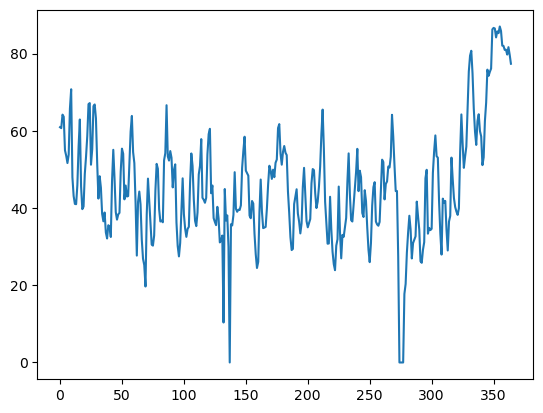

In [60]:
submit = pd.DataFrame({'datetime' : test_data.index, 'pred' : y_test_pred})

print(submit)
for i in test_data2[test_data2['close']==1].index:
    submit['pred'].iloc[i] = 0
    

plt.plot(submit['pred'])

submit.columns = submit.iloc[0]
print(submit)
submit.to_csv('signate_ligthGBM_oputuna_3.csv', index=False)